In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm 

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/data and weights/sensor_final.csv')

In [ ]:
df.shape

(119103, 24)

In [ ]:
df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
0,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
1,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
2,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,...,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963
3,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,...,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028
4,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,...,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093


In [ ]:
df.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49'],
      dtype='object')

In [ ]:
n_in = 10  

n_out = 5

val_size = 10

test_size = 5

In [ ]:
def lstm_train_data_transform(df, n_in, n_out,val_size,test_size):
    
  """ Changes data to the format for LSTM training 
        for sliding window approach """    
    
  encoder_input, final_output = list(), list()         # Prepare the list for the transformed data
  
  train_val = round(df.shape[0] * ((100 - test_size)/100))
  
  for i in range(train_val):                    # Loop of the entire data set
        
    total_steps = i + n_in + 1
        
    if total_steps >= train_val:               # if index is larger than the size of the dataset, we stop
            
      break        
        
    end_enc_inp = i + n_in                       # compute a new (sliding window) index for encoder input
                    
    final_out_end = end_enc_inp + 1
    
    seq_enc_input = df[i:end_enc_inp]                    # Get a sequence of data for x
            
    seq_final_out = df[end_enc_inp:final_out_end]
    
    encoder_input.append(seq_enc_input)                             # Append the list with sequencies
            
    final_output.append(seq_final_out)
    
  encoder_input = np.array(encoder_input)                           # Make final arrays
        
  final_output = np.array(final_output)
      
  train_size = round(df.shape[0] * ((100 - (val_size + test_size))/100))
                      
  encoder_input_train = encoder_input[:train_size]
      
  final_output_train = final_output[:train_size]
  
  encoder_input_val = encoder_input[train_size:]
      
  final_output_val = final_output[train_size:]
  
  encoder_input, final_output = list(), list()
  
  for i in range(df[train_val:].shape[0]):                    # Loop of the entire data set
        
    total_steps = i + n_in + n_out
        
    if total_steps >= df[train_val:].shape[0]:               # if index is larger than the size of the dataset, we stop
            
      break        
        
    end_enc_inp = i + n_in                       # compute a new (sliding window) index for encoder input
                    
    final_out_end = end_enc_inp + n_out
    
    seq_enc_input = df[i:end_enc_inp]                    # Get a sequence of data for x
            
    seq_final_out = df[end_enc_inp:final_out_end]
    
    encoder_input.append(seq_enc_input)                             # Append the list with sequencies
            
    final_output.append(seq_final_out)
        
  encoder_input = np.array(encoder_input)                           # Make final arrays
      
  final_output = np.array(final_output)
  
  encoder_input_test = encoder_input
      
  final_output_test = final_output
  
  return encoder_input_train, final_output_train, encoder_input_val, final_output_val, encoder_input_test, final_output_test

In [ ]:
encoder_input_train, final_output_train, encoder_input_val, final_output_val, encoder_input_test, final_output_test = lstm_train_data_transform(df,n_in,n_out,val_size,test_size)

In [ ]:
print(encoder_input_train.shape, final_output_train.shape, encoder_input_val.shape, final_output_val.shape, encoder_input_test.shape, final_output_test.shape)

(101238, 10, 24) (101238, 1, 24) (11899, 10, 24) (11899, 1, 24) (5940, 10, 24) (5940, 5, 24)


In [ ]:
encoder_input_train[0]

array([[ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.35243   ,  53.2118    ,  46.39757   , 638.8889    ,
         73.54598   ,  13.32465   ,  16.03733   ,  15.61777   ,
         15.01013   ,  37.86777   ,  48.17723   ,  32.08894   ,
          1.708474  ,  31.25      ,  6

In [ ]:
final_output_train[0]

array([[ 47.48264   ,  53.125     ,  46.39756775, 637.7314    ,
         76.05148   ,  13.41146   ,  16.16753   ,  15.65393   ,
         15.11863   ,  39.90199   ,  50.48941   ,  32.80076   ,
          1.678884  ,  32.55208   ,  75.52083   ,  30.98958   ,
         31.51041603,  41.40625   ,  39.35185   ,  54.97685   ,
         50.92593   ,  39.35185   , 190.9722    ,  71.18056   ]])

SCALING

In [ ]:
historical_max = np.expand_dims(np.max(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_max

array([[[ 55.77257,  56.03299,  48.22049, 671.9907 ,  99.98649,
          21.39034,  23.50984,  19.29253,  18.98871,  76.10686,
          60.     ,  45.     ,  31.18755, 547.9166 , 512.7604 ,
         219.0104 , 330.4688 , 302.0833 , 221.0648 , 220.1968 ,
         320.8912 , 196.7593 , 474.8264 , 241.3194 ]]])

In [ ]:
historical_min = np.expand_dims(np.min(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_min

array([[[2.24392400e+01, 3.73263900e+01, 3.32899300e+01, 3.10474500e+00,
         0.00000000e+00, 1.44675900e-02, 0.00000000e+00, 2.89351800e-02,
         7.23379600e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.31770800e+01, 3.02083300e+01, 2.39583300e+01,
         2.57812500e+01, 2.89062500e+01, 2.86458300e+01, 2.89351800e+01,
         3.06712971e+01, 3.09606476e+01, 3.03819400e+01, 3.00925900e+01]]])

In [ ]:
scaler = StandardScaler()

encoder_input_train = scaler.fit_transform(encoder_input_train.reshape(-1, encoder_input_train.shape[-1])).reshape(encoder_input_train.shape)

final_output_train = scaler.transform(final_output_train.reshape(-1, final_output_train.shape[-1])).reshape(final_output_train.shape)

encoder_input_val = scaler.transform(encoder_input_val.reshape(-1, encoder_input_val.shape[-1])).reshape(encoder_input_val.shape)

final_output_val = scaler.transform(final_output_val.reshape(-1, final_output_val.shape[-1])).reshape(final_output_val.shape)

In [ ]:
encoder_input_train[0]

array([[-0.54638625,  0.57284234,  1.36919253,  0.21391012,  0.0721432 ,
         0.10995165,  0.20145126,  0.41471617,  0.1216643 , -0.67450351,
         0.67632137,  0.17249462, -0.45936718, -0.42290415,  0.25472617,
        -0.66123223, -0.50200585, -0.18995393, -0.15566311,  2.30431839,
         0.45441958, -0.63264844,  0.61359206,  1.00942452],
       [-0.54638625,  0.57284234,  1.36919253,  0.21391012,  0.0721432 ,
         0.10995165,  0.20145126,  0.41471617,  0.1216643 , -0.67450351,
         0.67632137,  0.17249462, -0.45936718, -0.42290415,  0.25472617,
        -0.66123223, -0.50200585, -0.18995393, -0.15566311,  2.30431839,
         0.45441958, -0.63264844,  0.61359206,  1.00942452],
       [-0.41249738,  0.57284234,  1.41765184,  0.28343131, -0.16910629,
         0.01068602,  0.07732756,  0.48924862,  0.05793596, -0.59319311,
         0.75334965,  0.29622933, -0.45271537, -0.44197498,  0.19569793,
        -0.72463528, -0.50200609, -0.21833414, -0.19643251,  2.27554971,
  

In [ ]:
final_output_train[0]

array([[-0.34555295,  0.52946752,  1.41765058,  0.26560398,  0.03833994,
         0.10995165,  0.24919724,  0.54246927,  0.21725681, -0.3348999 ,
         1.02609164,  0.38686388, -0.45997273, -0.3466223 ,  0.53511229,
        -0.66123223, -0.53244382, -0.24671327, -0.19643285,  1.23987032,
         0.45441958, -0.49253845,  1.1890676 ,  1.27807549]])

CHECKPOINTS

In [ ]:
#callbacks

filepath = '/content/drive/My Drive/data and weights/option_3/a'

filepath = filepath + "/model-{epoch:02d}.hdf5"

checkpoint_cb = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

lr_cb = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001,verbose=1)

es_cp = EarlyStopping(monitor='val_loss', patience=5)

cb = [checkpoint_cb, lr_cb, es_cp]

MODELLING

In [ ]:
batch_size = 64  # Batch size for training.

epochs = 100  # Number of epochs to train for.

units = 256  # no of lstm units

features = 24

In [ ]:
# Define an input sequence and process it.

input = Input(shape=(n_in,features))

lstm1 = LSTM(units, return_sequences=True, return_state=True, dtype='float64')

lstm1_output, hidden, cell = lstm1(input)

states = [hidden, cell]

lstm2 = LSTM(units, dtype='float64')

lstm2_output = lstm2(lstm1_output, initial_state=states)

lstm2_dense = Dense(features, dtype='float64')

lstm2_output = tf.expand_dims(lstm2_dense(lstm2_output),1)

model = Model(input, lstm2_output)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 24)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 10, 256),    287744      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          525312      ['lstm[0][0]',                   
                                                                  'lstm[0][1]',               

In [ ]:
model.fit(
    x = encoder_input_train,
    y = final_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(encoder_input_val,final_output_val),
    callbacks=cb
)

Epoch 1/100
1580/1582 [============================>.] - ETA: 0s - loss: 0.0789
Epoch 1: val_loss improved from inf to 1.67254, saving model to /content/drive/My Drive/data and weights/option_3/a/model-01.hdf5
1582/1582 [==============================] - 47s 25ms/step - loss: 0.0788 - val_loss: 1.6725 - lr: 0.0010
Epoch 2/100
1581/1582 [============================>.] - ETA: 0s - loss: 0.0344
Epoch 2: val_loss did not improve from 1.67254
1582/1582 [==============================] - 38s 24ms/step - loss: 0.0344 - val_loss: 2.3534 - lr: 0.0010
Epoch 3/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0283
Epoch 3: val_loss did not improve from 1.67254
1582/1582 [==============================] - 38s 24ms/step - loss: 0.0283 - val_loss: 1.8216 - lr: 0.0010
Epoch 4/100
1581/1582 [============================>.] - ETA: 0s - loss: 0.0245
Epoch 4: val_loss improved from 1.67254 to 1.29606, saving model to /content/drive/My Drive/data and weights/option_3/a/model-04.hdf5
1582

INFERENCE

In [ ]:
def inference(input):
  
  input = scaler.transform(input)
        
  input = tf.expand_dims(input,0)
      
  all_outputs = []
  
  pred = model_new.predict(input,verbose = 0)
              
  all_outputs.append(pred)

  for i in range(n_out-1):
    
    input = input[:,1:,:]
                    
    input = tf.concat([input,all_outputs[-1]],axis=1)
        
    pred = model_new.predict(input,verbose = 0)
            
    all_outputs.append(pred)        
            
  all_outputs = np.concatenate(all_outputs,axis=1)
          
  all_outputs = scaler.inverse_transform(all_outputs.reshape(-1, all_outputs.shape[-1])).reshape(all_outputs.shape)

  for i in range(all_outputs.shape[1]):
    
    for j in range(all_outputs.shape[2]):
      
      if all_outputs[:,i,j] < historical_min[0][0][j]:
        
        all_outputs[:,i,j] = historical_min[0][0][j]
            
      elif all_outputs[:,i,j] > historical_max[0][0][j]:
            
        all_outputs[:,i,j] = historical_max[0][0][j]
                
  return all_outputs          

PERFORMANCE ON UNSEEN DATA

In [ ]:
## loading saved model
model_new = load_model(r'/content/drive/My Drive/data and weights/option_3/a/model-09.hdf5')

In [ ]:
model_new

In [ ]:
model_new.layers

In [ ]:
eg_in = encoder_input_test[-100].copy()   #random input

eg_in

array([[ 48.91493   ,  51.47569   ,  43.14236069, 636.3426    ,
         69.85662   ,  13.5055    ,  17.22367   ,  16.82581   ,
         16.13136   ,  40.24953   ,  53.74285   ,  29.63692   ,
         23.01407   ,  29.6875    ,  82.55208   ,  30.46875   ,
         31.77083206,  43.48958   ,  36.16898   ,  46.875     ,
         44.84954   ,  38.19444   , 229.1667    ,  77.83565   ],
       [ 49.00174   ,  51.43229   ,  43.14236   , 639.1204    ,
         68.8463    ,  13.55613   ,  17.07899   ,  16.78241   ,
         16.05179   ,  40.72644   ,  53.44472   ,  29.06578   ,
         22.30173   ,  29.94792   ,  78.64583   ,  30.46875   ,
         31.77083206,  43.22916   ,  35.87963   ,  45.42824   ,
         43.69213   ,  38.19444275, 229.1667    ,  75.81019   ],
       [ 48.87152   ,  51.47569   ,  43.05555   , 632.1759    ,
         69.72878   ,  13.53443   ,  17.13686   ,  16.42072   ,
         16.05903   ,  41.29969   ,  53.9871    ,  29.45661   ,
         22.70048   ,  29.94792   ,  7

In [ ]:
eg_out = final_output_test[-100].copy()

eg_out

array([[ 49.08854   ,  51.47569   ,  43.01215   , 645.4861    ,
         68.50384   ,  13.67911   ,  17.1224    ,  16.74624   ,
         16.0952    ,  42.88582   ,  54.01841   ,  31.83176   ,
         23.79693   ,  31.25      ,  85.15625   ,  33.07291   ,
         32.29166   ,  46.09375   ,  35.01157   ,  37.32639   ,
         46.2963    ,  41.66667   , 246.2384    ,  66.55093   ],
       [ 49.08854   ,  51.47569   ,  43.01215   , 645.4861    ,
         68.50384   ,  13.67911   ,  17.1224    ,  16.74624   ,
         16.0952    ,  42.88582   ,  54.01841   ,  31.83176   ,
         23.79693   ,  31.25      ,  85.15625   ,  33.07291   ,
         32.29166   ,  46.09375   ,  35.01157   ,  37.32639   ,
         46.2963    ,  41.66667   , 246.2384    ,  66.55093   ],
       [ 49.04514   ,  51.47569275,  43.01214981, 625.463     ,
         70.17707   ,  13.5923    ,  17.17303   ,  16.41348   ,
         16.17477   ,  41.48079   ,  54.24043   ,  31.85591   ,
         20.18276   ,  31.25      ,  8

In [ ]:
pred_out = inference(eg_in)

pred_out

array([[[ 48.78923591,  51.40140935,  42.9870456 , 636.18016058,
          70.31752086,  13.77543521,  17.25818158,  16.55334784,
          16.1273022 ,  43.05704411,  53.29617531,  32.08058241,
          22.71925169,  29.28111999,  87.05199777,  32.57426448,
          32.2355506 ,  44.91182994,  35.28733611,  37.19321897,
          43.17621096,  40.8155003 , 260.11999239,  68.43403244],
        [ 48.5935568 ,  51.32557791,  42.95916016, 634.85592116,
          70.92094541,  13.84901403,  17.25982344,  16.53131996,
          16.13198326,  41.36690195,  52.78484688,  32.16622414,
          22.62361347,  28.63888542,  86.66875117,  31.59094718,
          32.09514183,  44.46227334,  35.38878526,  37.24705123,
          43.52640249,  40.92064683, 245.80724518,  68.68466378],
        [ 48.46947507,  51.25020882,  42.90628856, 635.24821375,
          72.00455022,  13.88283185,  17.2866342 ,  16.52897416,
          16.1321634 ,  39.76142018,  52.40068065,  32.48633388,
          22.75473477, 

In [ ]:
mean_squared_error(eg_out, pred_out.reshape(-1,pred_out.shape[-1]),squared=False)

2.109109115394666

In [ ]:
pred = []

for i in tqdm(range(encoder_input_test.shape[0])):
    
    x = encoder_input_test[i].copy()
        
    x = inference(x)
    
    pred.append(x)
    
pred = np.concatenate(pred,0)

100%|██████████| 5940/5940 [33:37<00:00,  2.94it/s]


In [ ]:
pred.shape

(5940, 5, 24)

Total rmse

In [ ]:
mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1]), pred.reshape(-1,pred.shape[-1]),squared=False)

2.465894999091357

Total rmse f1

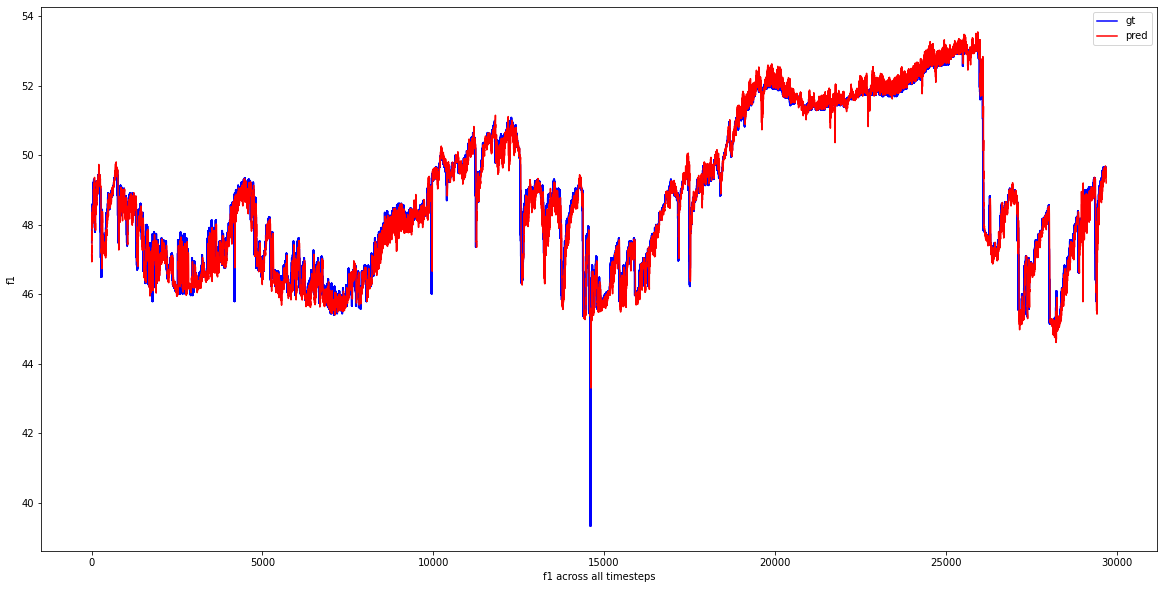

0.40027151234915775


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,0],c='red', label="pred")

plt.legend()

plt.xlabel('f1 across all timesteps')

plt.ylabel('f1')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], pred.reshape(-1,pred.shape[-1])[:,0],squared=False))

Total rmse f2

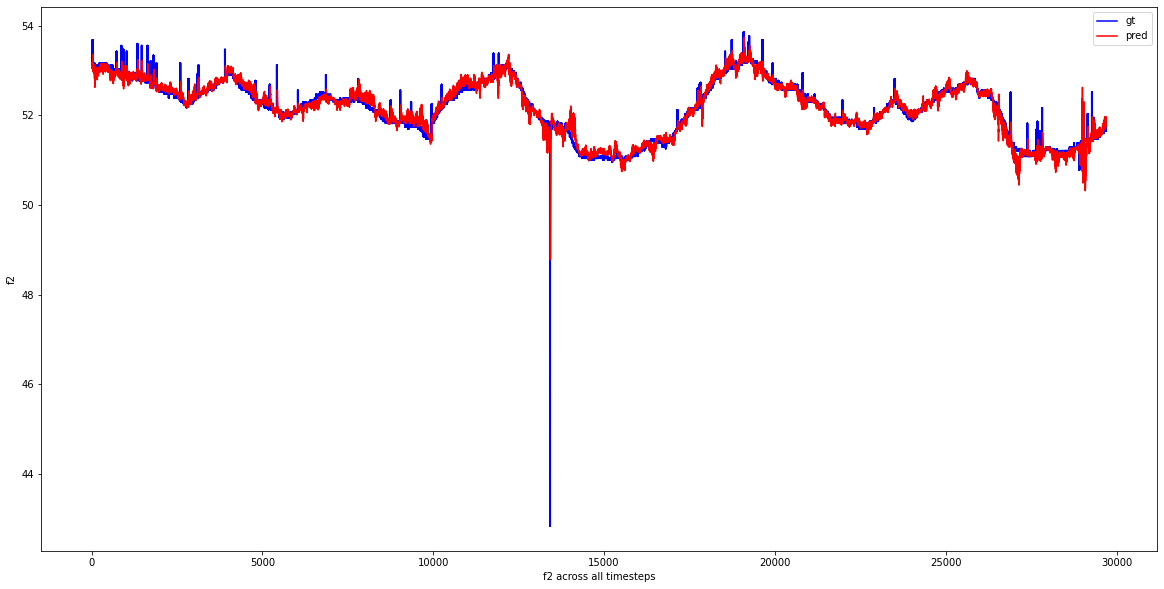

0.18346354775903428


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,1],c='red', label="pred")

plt.legend()

plt.xlabel('f2 across all timesteps')

plt.ylabel('f2')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], pred.reshape(-1,pred.shape[-1])[:,1],squared=False))

Total rmse f3

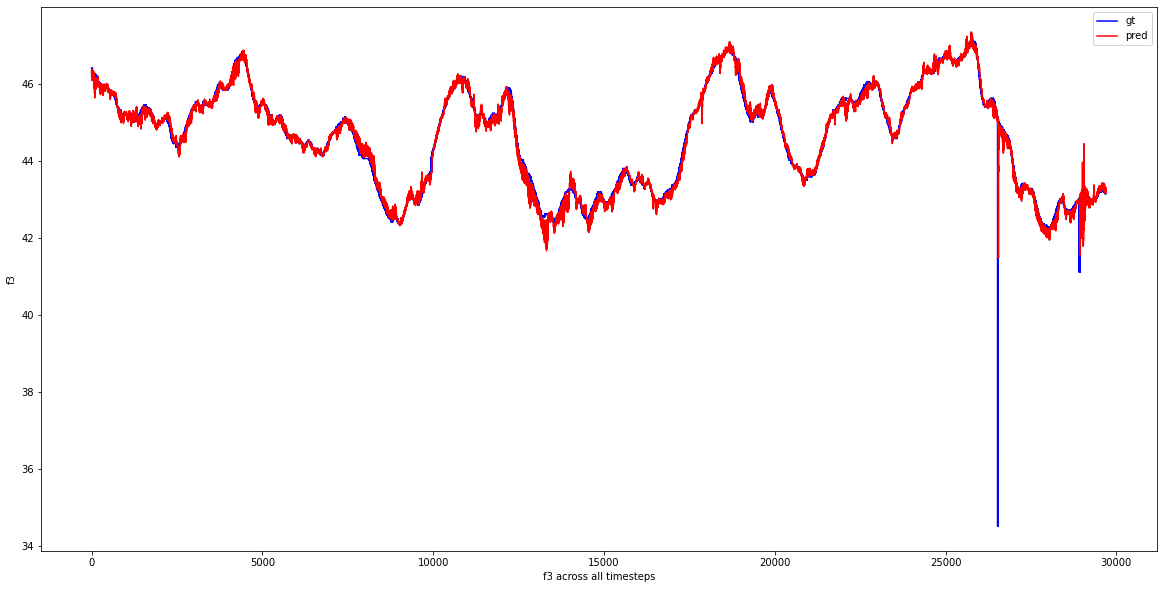

0.2026245760329128


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,2],c='red', label="pred")

plt.legend()

plt.xlabel('f3 across all timesteps')

plt.ylabel('f3')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], pred.reshape(-1,pred.shape[-1])[:,2],squared=False))

Total rmse f4

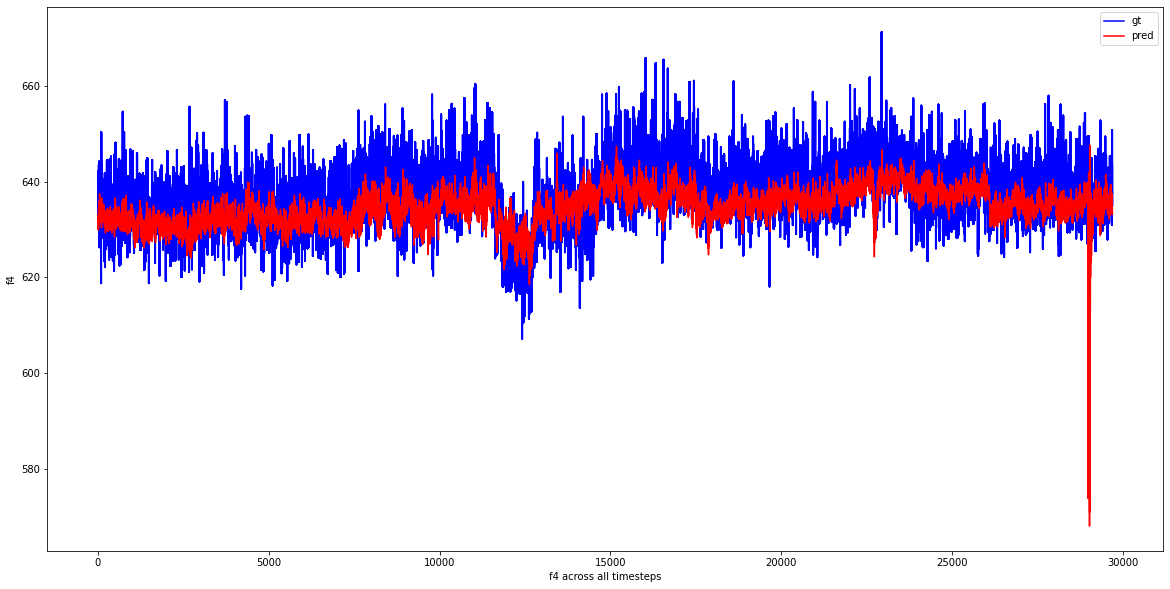

7.739744222283937


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,3],c='red', label="pred")

plt.legend()

plt.xlabel('f4 across all timesteps')

plt.ylabel('f4')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], pred.reshape(-1,pred.shape[-1])[:,3],squared=False))

Total rmse f5

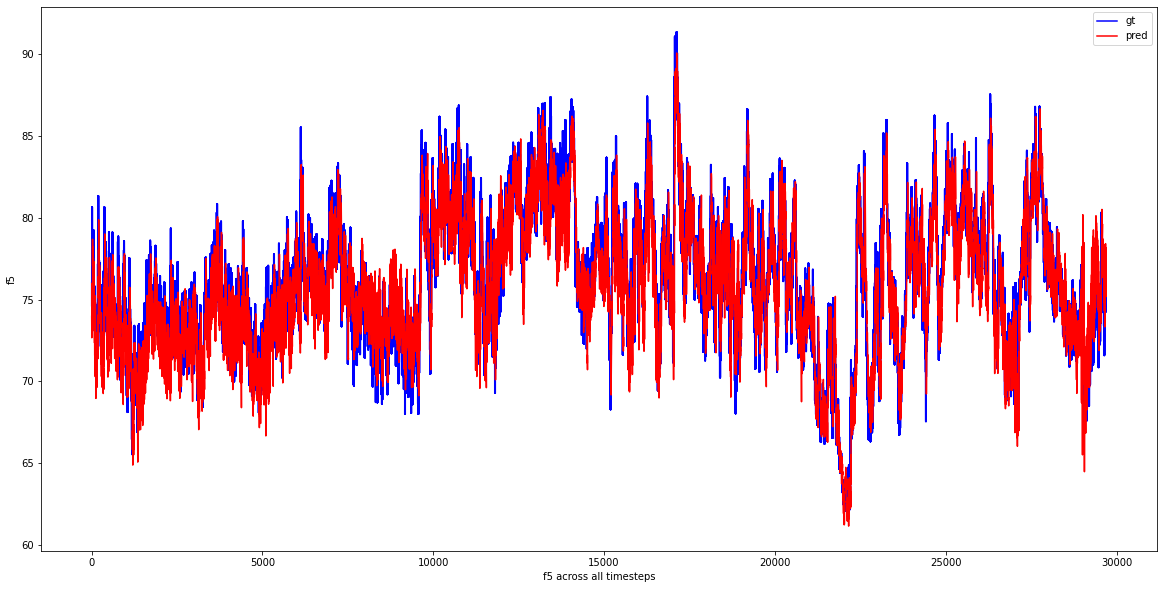

2.3274277803535632


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,4],c='red', label="pred")

plt.legend()

plt.xlabel('f5 across all timesteps')

plt.ylabel('f5')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], pred.reshape(-1,pred.shape[-1])[:,4],squared=False))

Total rmse f6

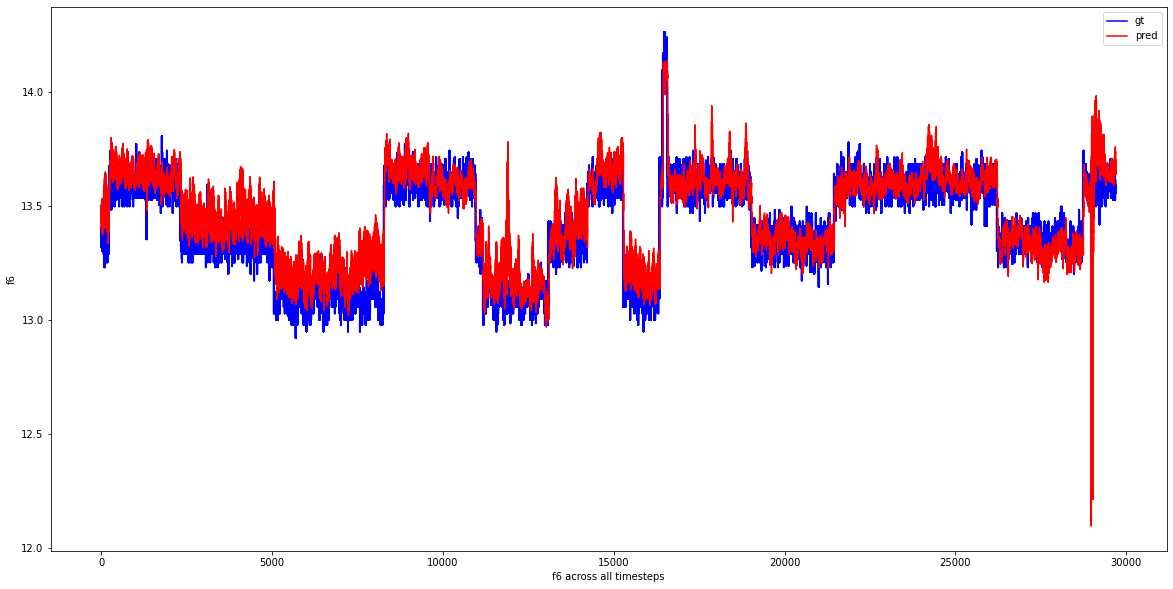

0.11382787823519096


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,5],c='red', label="pred")

plt.legend()

plt.xlabel('f6 across all timesteps')

plt.ylabel('f6')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], pred.reshape(-1,pred.shape[-1])[:,5],squared=False))

Total rmse f7

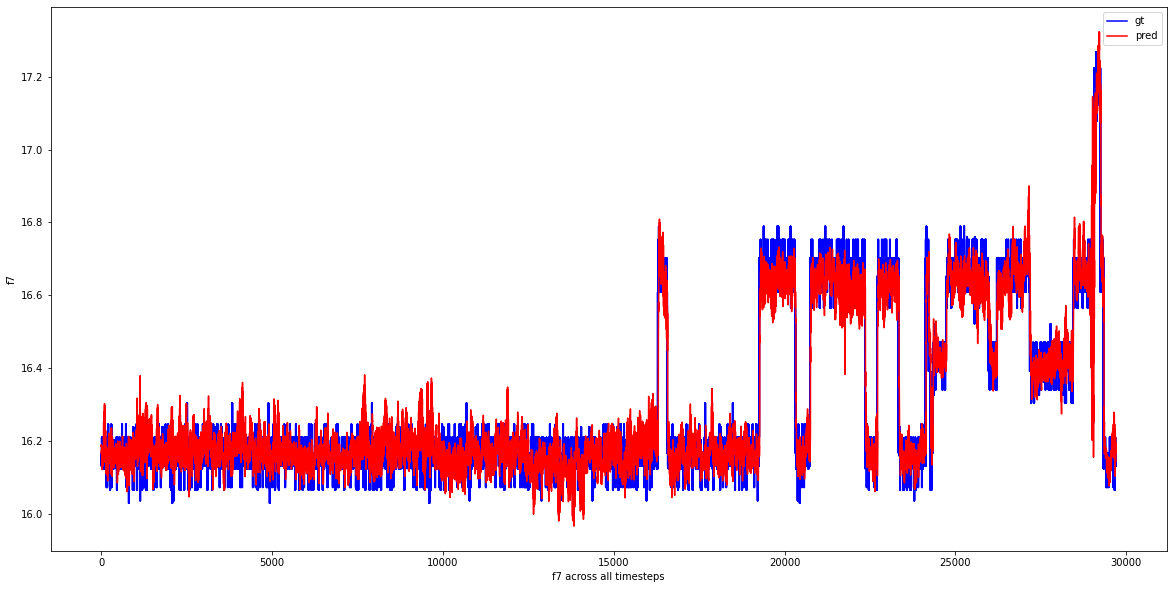

0.07635605742632065


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,6],c='red', label="pred")

plt.legend()

plt.xlabel('f7 across all timesteps')

plt.ylabel('f7')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], pred.reshape(-1,pred.shape[-1])[:,6],squared=False))

Total rmse f8

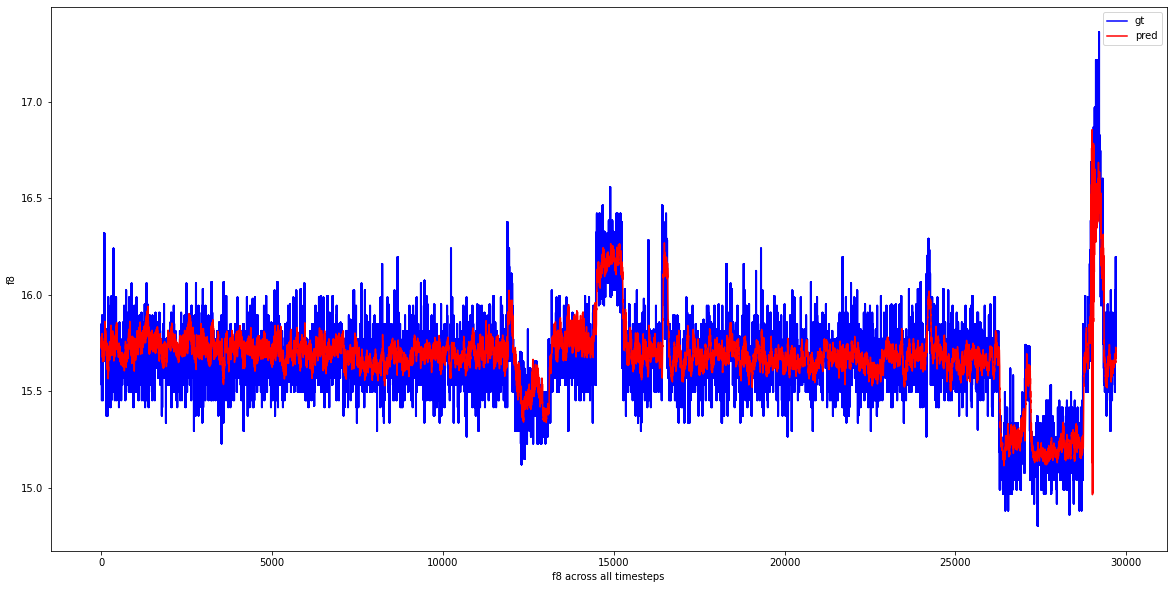

0.1590081123715714


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,7],c='red', label="pred")

plt.legend()

plt.xlabel('f8 across all timesteps')

plt.ylabel('f8')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], pred.reshape(-1,pred.shape[-1])[:,7],squared=False))

Total rmse f9

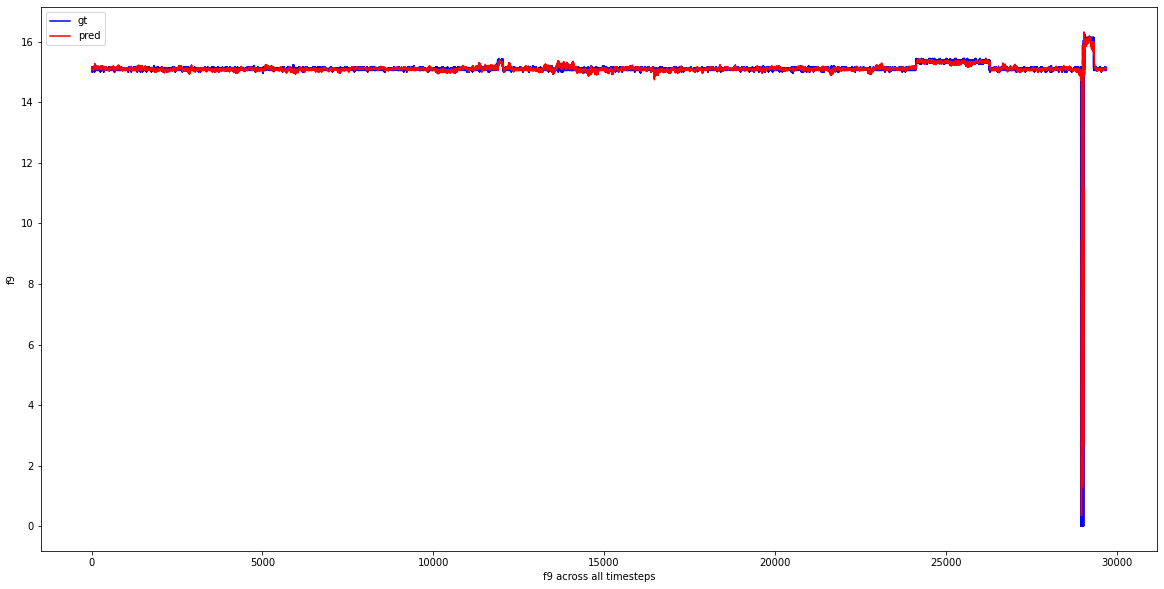

0.46712411428946493


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,8],c='red', label="pred")

plt.legend()

plt.xlabel('f9 across all timesteps')

plt.ylabel('f9')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], pred.reshape(-1,pred.shape[-1])[:,8],squared=False))

Total rmse f10

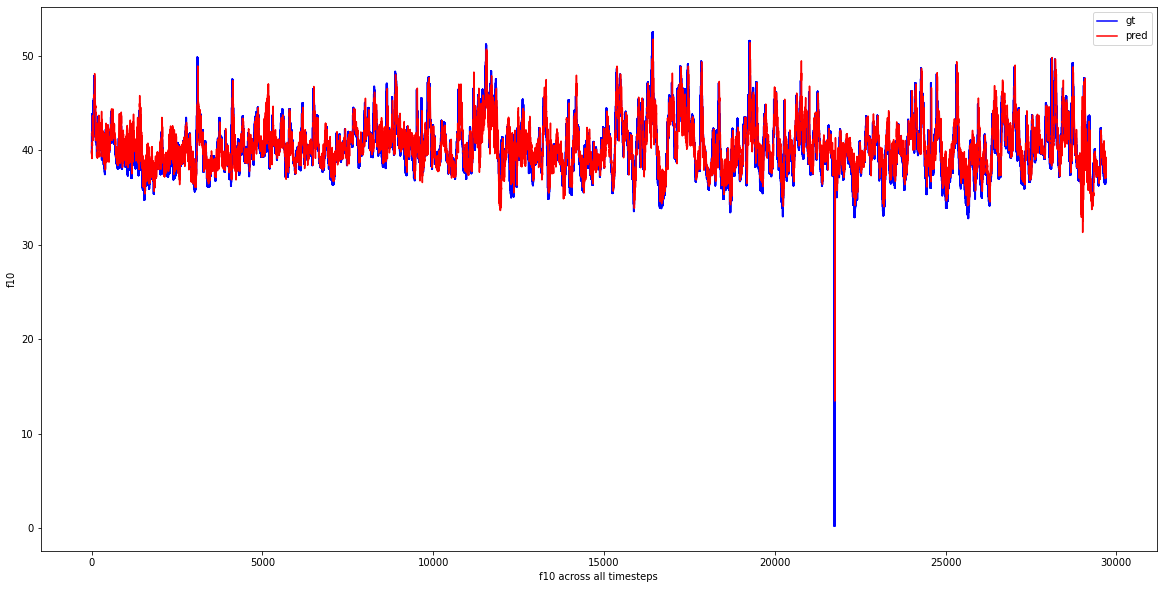

1.863735978858054


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,9],c='red', label="pred")

plt.legend()

plt.xlabel('f10 across all timesteps')

plt.ylabel('f10')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], pred.reshape(-1,pred.shape[-1])[:,9],squared=False))

Total rmse f11

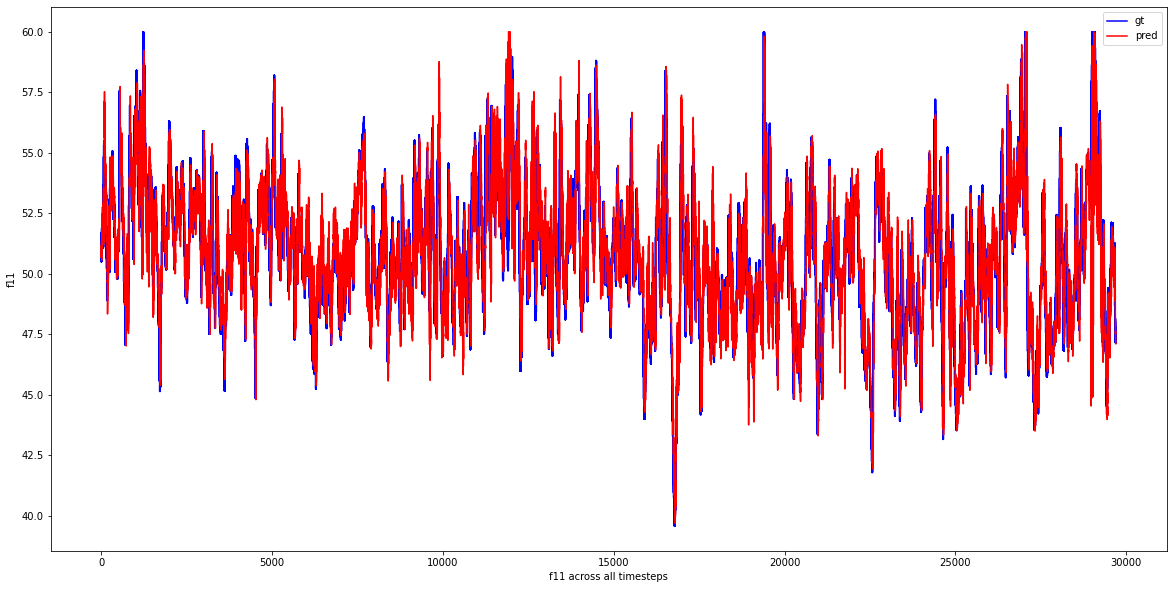

1.5393616982697995


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,10],c='red', label="pred")

plt.legend()

plt.xlabel('f11 across all timesteps')

plt.ylabel('f11')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], pred.reshape(-1,pred.shape[-1])[:,10],squared=False))

Total rmse f12

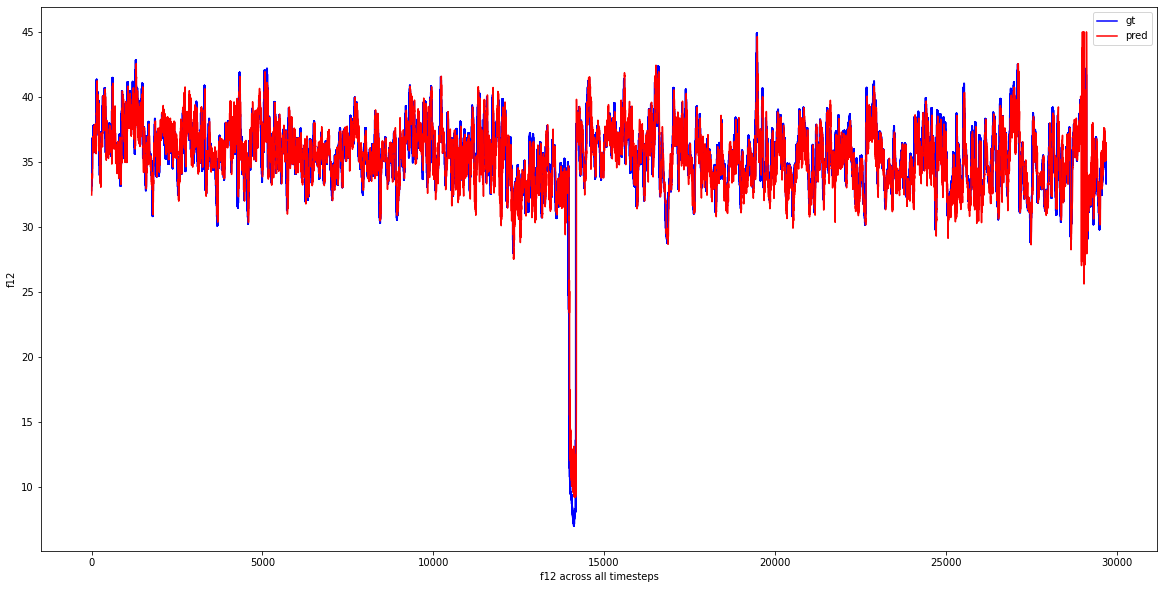

1.6421720386134153


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,11],c='red', label="pred")

plt.legend()

plt.xlabel('f12 across all timesteps')

plt.ylabel('f12')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], pred.reshape(-1,pred.shape[-1])[:,11],squared=False))

Total rmse f13

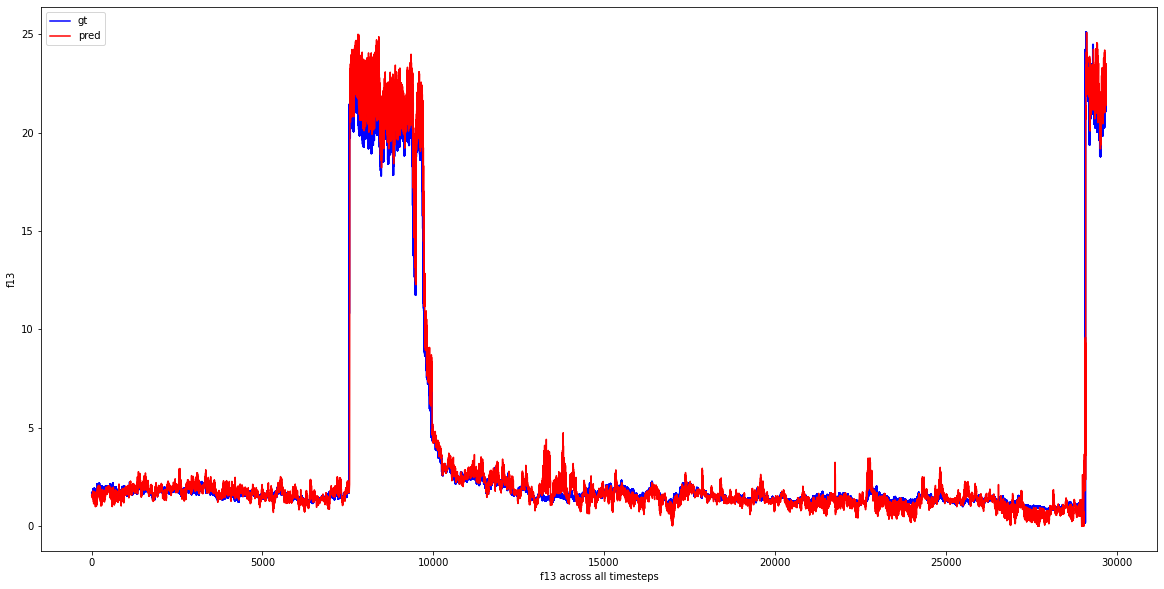

0.8836739049808794


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,12],c='red', label="pred")

plt.legend()

plt.xlabel('f13 across all timesteps')

plt.ylabel('f13')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], pred.reshape(-1,pred.shape[-1])[:,12],squared=False))

Total rmse f14

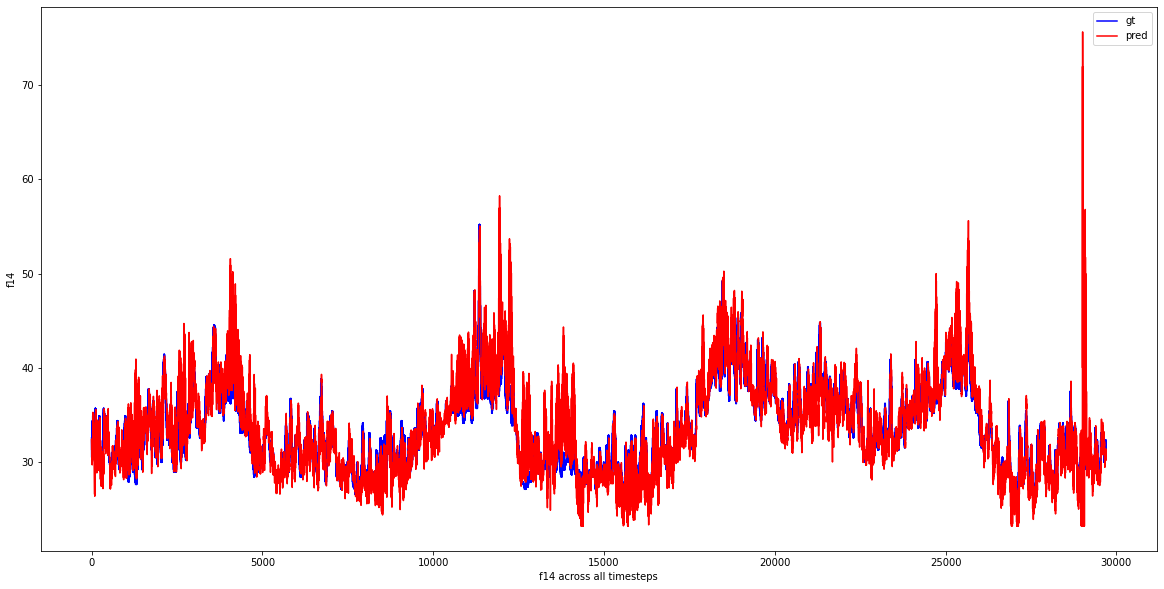

2.607326948090494


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,13],c='red', label="pred")

plt.legend()

plt.xlabel('f14 across all timesteps')

plt.ylabel('f14')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], pred.reshape(-1,pred.shape[-1])[:,13],squared=False))

Total rmse f15

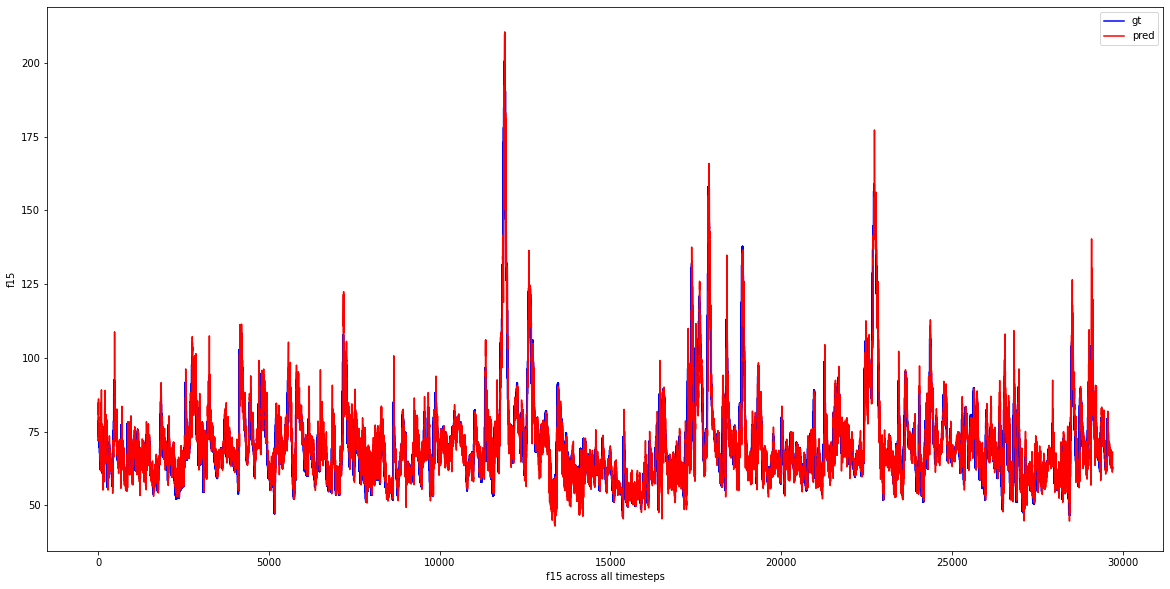

6.217147921860673


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,14],c='red', label="pred")

plt.legend()

plt.xlabel('f15 across all timesteps')

plt.ylabel('f15')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], pred.reshape(-1,pred.shape[-1])[:,14],squared=False))

Total rmse f16

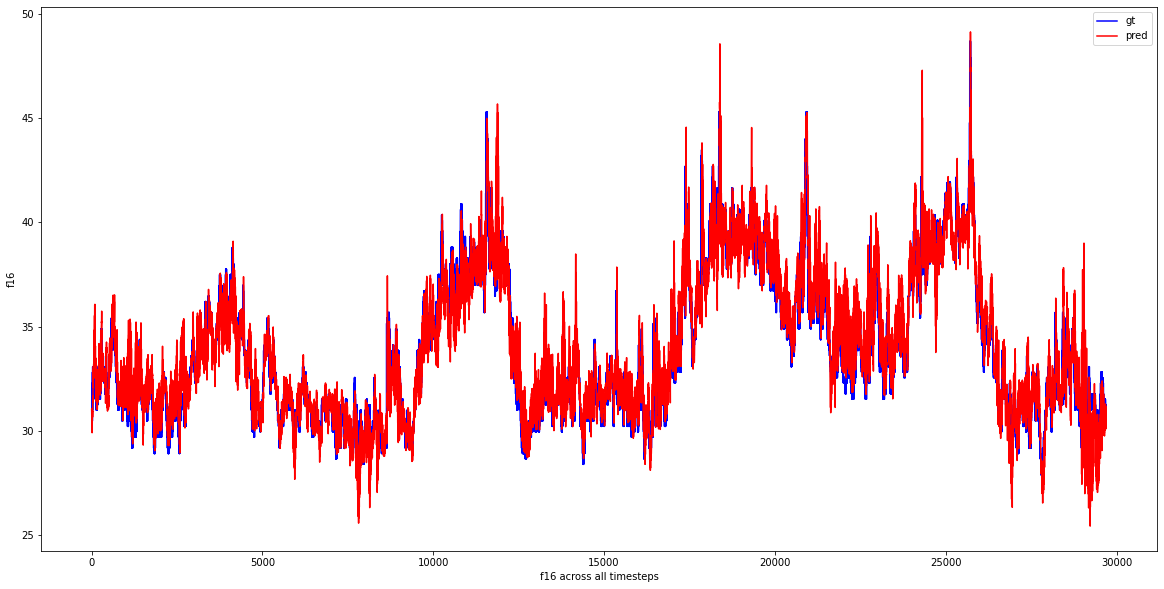

1.273626941412028


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,15],c='red', label="pred")

plt.legend()

plt.xlabel('f16 across all timesteps')

plt.ylabel('f16')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], pred.reshape(-1,pred.shape[-1])[:,15],squared=False))

Total rmse f17

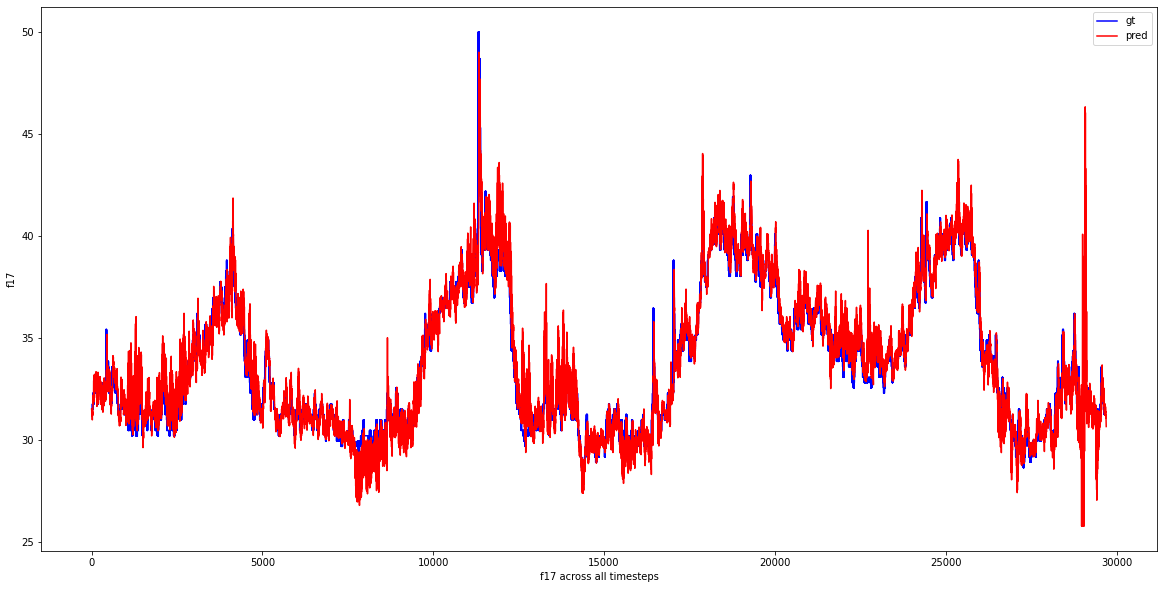

0.9580681989723574


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,16],c='red', label="pred")

plt.legend()

plt.xlabel('f17 across all timesteps')

plt.ylabel('f17')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], pred.reshape(-1,pred.shape[-1])[:,16],squared=False))

Total rmse f18

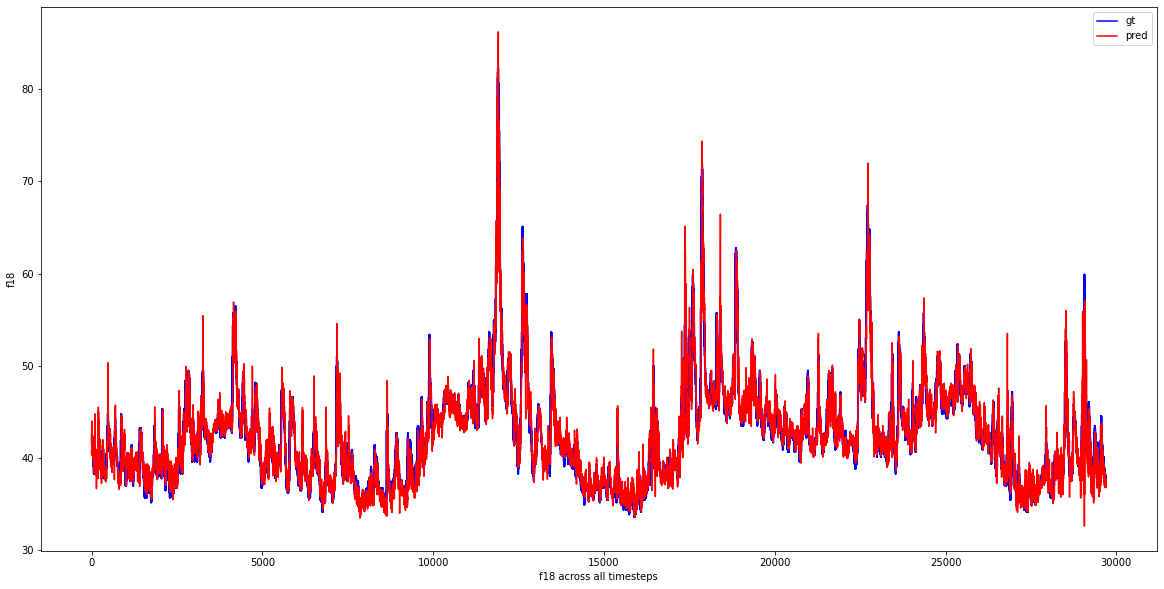

1.5884941107666906


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,17],c='red', label="pred")

plt.legend()

plt.xlabel('f18 across all timesteps')

plt.ylabel('f18')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], pred.reshape(-1,pred.shape[-1])[:,17],squared=False))

Total rmse f19

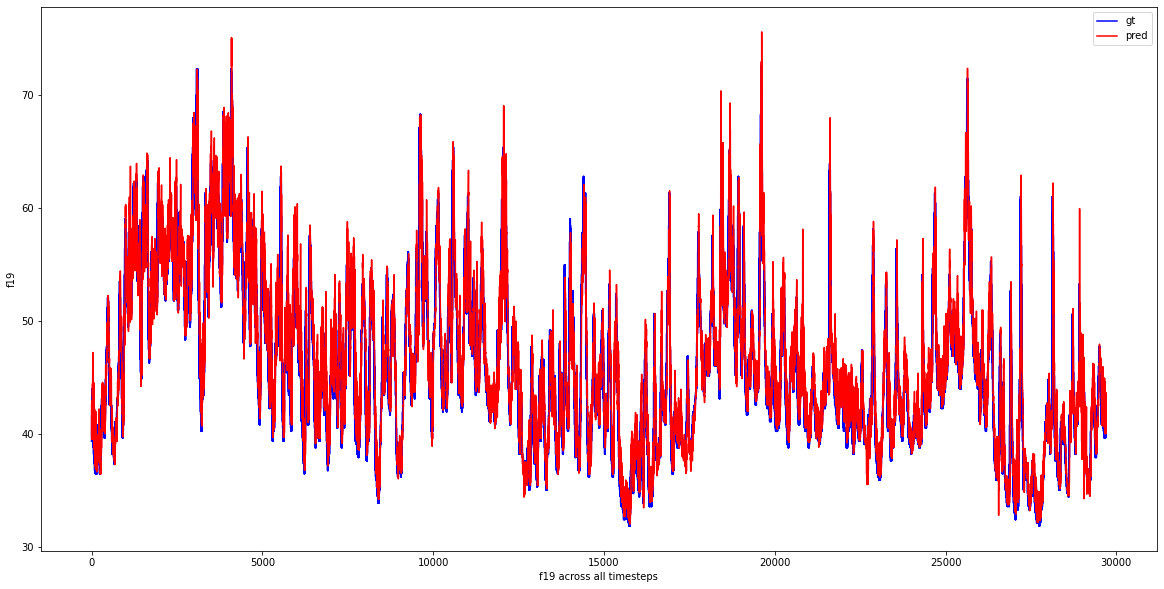

2.5615577245018546


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,18],c='red', label="pred")

plt.legend()

plt.xlabel('f19 across all timesteps')

plt.ylabel('f19')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], pred.reshape(-1,pred.shape[-1])[:,18],squared=False))

Total rmse f20

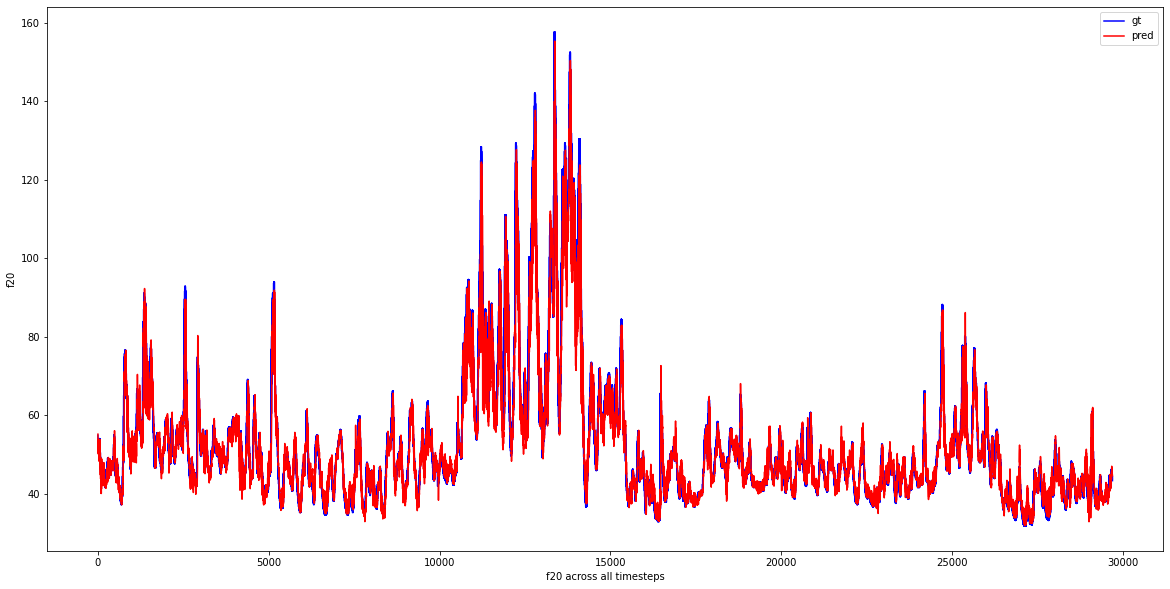

4.257385331113137


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,19],c='red', label="pred")

plt.legend()

plt.xlabel('f20 across all timesteps')

plt.ylabel('f20')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], pred.reshape(-1,pred.shape[-1])[:,19],squared=False))

Total rmse f21

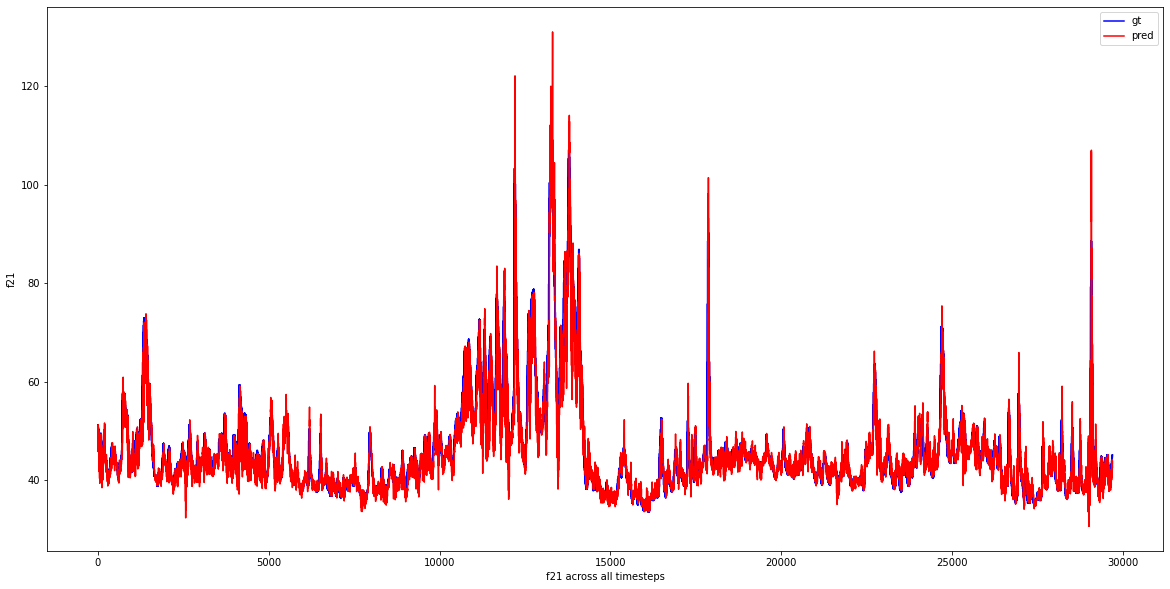

2.9526837013531746


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,20],c='red', label="pred")

plt.legend()

plt.xlabel('f21 across all timesteps')

plt.ylabel('f21')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], pred.reshape(-1,pred.shape[-1])[:,20],squared=False))

Total rmse f22

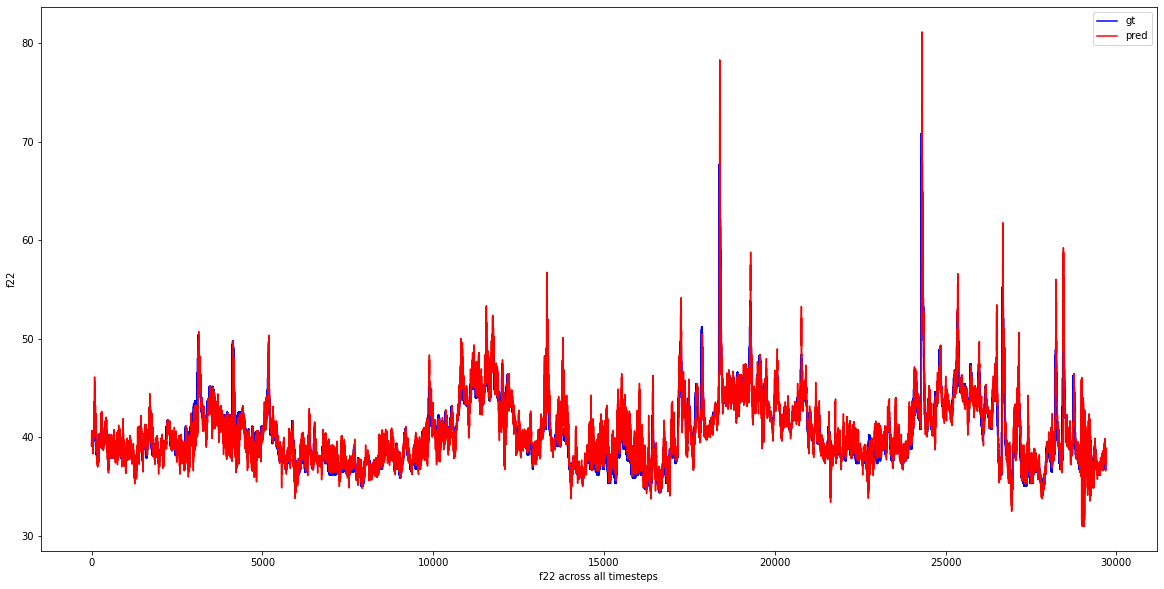

1.5243239726061872


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,21],c='red', label="pred")

plt.legend()

plt.xlabel('f22 across all timesteps')

plt.ylabel('f22')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], pred.reshape(-1,pred.shape[-1])[:,21],squared=False))

Total rmse f23

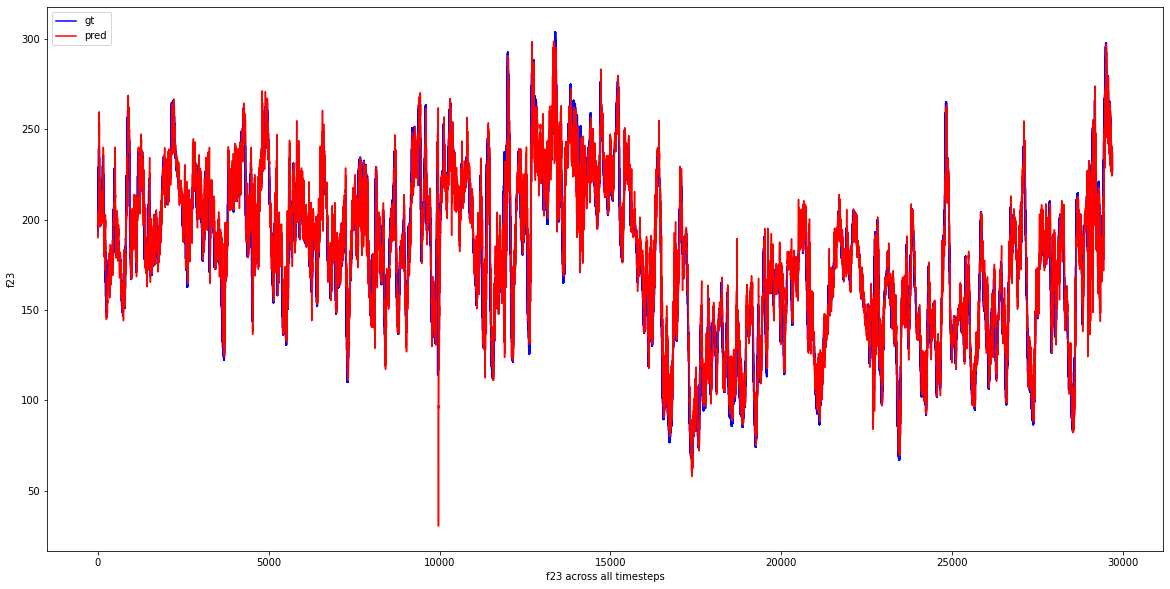

13.426241379009744


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,22],c='red', label="pred")

plt.legend()

plt.xlabel('f23 across all timesteps')

plt.ylabel('f23')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], pred.reshape(-1,pred.shape[-1])[:,22],squared=False))

Total rmse f24

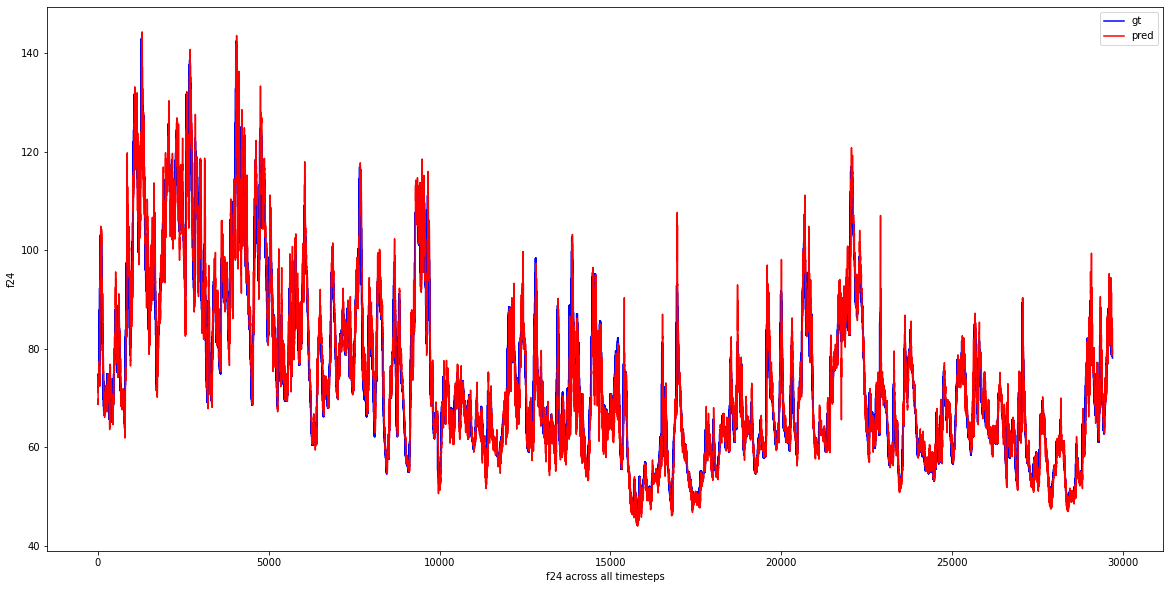

4.215832326682903


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,23],c='red', label="pred")

plt.legend()

plt.xlabel('f24 across all timesteps')

plt.ylabel('f24')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], pred.reshape(-1,pred.shape[-1])[:,23],squared=False))